In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

#read in data
data = pd.read_csv('cars_cleaned.csv')

#### missing values #####
data.dropna(inplace=True)#there are only a few dozen missing values so drop those rows

#cleaning
data = data[data.odometer<1e6] #drop rows where the odometer is very high
data = data[data.price<1e5] #drop rows where the price is very high

data

,condition,drive,fuel,location,odometer,paint color,price,sale type,title status,transmission,...,year,age,make_,model,pos_words,neg_words,low_text,model0,model1,model2
0,good,4wd,gas,vancouver,281000,white,5500,owner,rebuilt,automatic,...,2007,14,bmw,x3,False,False,False,x3,None,None
1,unknown,fwd,gas,vancouver,140000,unknown,600,owner,clean,automatic,...,1984,37,honda,accord,False,False,False,accord,None,None
2,excellent,rwd,diesel,vancouver,110000,white,67000,owner,clean,automatic,...,2008,13,gmc,c7500,False,False,False,c7500,None,None
3,unknown,fwd,gas,vancouver,243000,unknown,4000,owner,clean,automatic,...,2003,18,acura,rsx,True,False,False,rsx,None,None
4,salvage,fwd,gas,vancouver,225000,black,1500,owner,salvage,automatic,...,2005,16,acura,rsx,False,False,False,rsx,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37336,excellent,fwd,gas,port coquitlam,28356,black,28995,dealer,clean,automatic,...,2020,1,mazda,mazda6,False,False,False,mazda6,None,None
37337,excellent,fwd,gas,port coquitlam,23820,black,27995,dealer,clean,automatic,...,2020,1,toyota,camry,False,False,False,camry,None,None
37338,excellent,4wd,gas,port coquitlam,129449,white,29800,dealer,clean,automatic,...,2016,5,ford,f-150,False,False,False,f-150,None,None
37339,excellent,4wd,gas,port coquitlam,31512,silver,28995,dealer,clean,automatic,...,2020,1,ford,escape,False,False,False,escape,None,None


GridSearchCV fitting...
{'num_leaves': 50} -> 2669.7123251740877
{'num_leaves': 100} -> 2512.358073781562
{'num_leaves': 200} -> 2470.3686642084235
{'num_leaves': 400} -> 2483.760793185689
{'num_leaves': 800} -> 2526.4507327948113


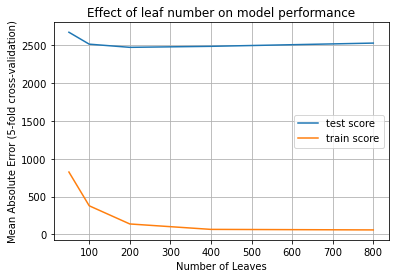

In [4]:
#### create training and validation data ####
X = data.copy()
y = X.pop('price')

#locating categorical and numeric columns
cat_cols = X.columns[X.dtypes.values=='O']#categorical columns
numeric_cols = [col for col in X.columns if col not in cat_cols] #the rest are numeric

for col in cat_cols:
    X[col] = X[col].astype('category')#change data type so it can be handled directly by lightgbm

#split training and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=41)#hold out 20% of data for testing

#The parameters for the model were found by a grid search. The code below demonstrates the grid seach for 'num_leaves'
model = LGBMRegressor(num_leaves = 200, 
                      min_child_samples=10,
                      random_state = 0, 
                      n_estimators = 1000, 
                      metric='l1')#Mean absolute error metric

params = {
    'num_leaves': [50, 100, 200, 400, 800],#repeat grid search over number of leaves to find optimum number
         }

searchCV = GridSearchCV(model, scoring='neg_mean_absolute_error', cv=5, param_grid=params, return_train_score=True)
print('GridSearchCV fitting...')
searchCV.fit(X_train, y_train)
scores = -1*searchCV.cv_results_['mean_test_score']
train_scores = -1*searchCV.cv_results_['mean_train_score']
params_out = searchCV.cv_results_['params']
for i in range(0, len(scores)):
  print(params_out[i], '->', scores[i])

x = params['num_leaves']
plt.plot(x, scores, label = 'test score')
plt.plot(x, train_scores, label = 'train score')
plt.title('Effect of leaf number on model performance')
plt.xlabel('Number of Leaves')
plt.ylabel('Mean Absolute Error (5-fold cross-validation)')
plt.legend()
plt.grid()
plt.show()

C:\Users\a_sylvester\Anaconda3\envs\cars\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\a_sylvester\Anaconda3\envs\cars\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\a_sylvester\Anaconda3\envs\cars\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


train score: 63.64928897307801
test score: 2289.079545714927


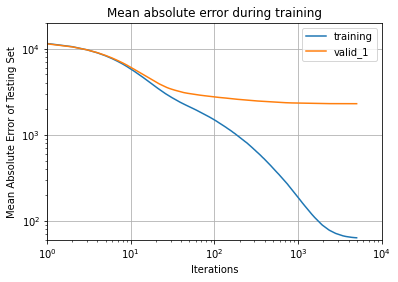

In [6]:
#we will now use the paramters found in the last step to fit the model to the training data and observe 
#the train/test score over the number of boosting iterations
evals_result={}

params = {#model paramters
    'task': 'train',
    'num_leaves': 200,
    'min_child_samples':10,
    'verbose':-1, 
    'n_estimators':5000,#number of boosting rounds
    'metric': 'l1',
    'random_state':0,}

train = lgb.Dataset(X_train, y_train)#training and testing dataset
test = lgb.Dataset(X_test, y_test)

#fit on training data with early stopping
model = lgb.train(params, train, early_stopping_rounds=25, valid_sets= [train, test], evals_result=evals_result, verbose_eval=False)

#final training prediction and errer
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print('train score:', mae)
#final testing prediction and error
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('test score:', mae)

#plot the error throughout the fitting process
lgb.plot_metric(evals_result, metric='l1')
plt.yscale('log')
plt.xscale('log')
plt.title('Mean absolute error during training')
plt.ylabel('Mean Absolute Error of Testing Set')
plt.ylim(6e1, 2e4)
plt.xlim(1, 10000)
plt.show()

In [7]:
#As seen above, after 5000 boosting iterations, the validation score is no longer improving so we can use that in our final model
#The final step is to fit our model to ALL of the data with the parameters we have found above.

train_final = lgb.Dataset(X, y)#final training dataset is all the data
model = lgb.train(params, train_final)#fit the final model

C:\Users\a_sylvester\Anaconda3\envs\cars\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
